<a href="https://colab.research.google.com/github/badlogic/genai-workshop/blob/main/01_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised learning
In supervised learning, our goal is to create a model that learns how to map inputs to outputs, based on examples of input-output pairs.

The output values can be limited to a fixed set of categories, or **classes**. For example, in spam detection, we learn to map from an email text to the two possible output values `spam` or `not spam`. This type of task is called **classification**.

We can also learn a mapping from an input value to a continuous output value. For example, we can learn to map from the number of cylinders, maker, and age of a car to its fuel efficiency given in liters per 100 kilometers. This type of task is called **regression**.

We can use supervised **machine learning models** for both of these tasks.


## Data

Before any learning can happen, we need to identify and collect data we want to learn from. Data is abundant and can be sourced from various platforms such as the internet, personal devices, or enterprise databases. However, not all data is immediately suitable for learning. For example, text data may be stored in binary formats like PDF, or markup formats like HTML; image or video data may be too big to handle or simply have the wrong aspect ratio; time series data may have missing values or outliers; or the data is "polluted" in some way, which all makes learning hard or impossible.


### Data Preprocessing
Generally, we need to apply **data preprocessing** in some way, to bring it into a format and onto a quality level so it can serve as input to a machine learning model. For example, for learning how to detect spam, we'd collect thousands or hundreds of thousands of emails and extract the raw text by stripping any markup or formatting. Each resulting raw email text could possibly then be used as a direct input to the machine learning model. One such input is then generally referred to as a **sample**, as in: a sample from the set of all possible emails. However, usually, raw text (or audio, or images) can seldomly be passed to a model.

Instead, raw data often has to be transformed to a numerical representation, such as **feature** vectors, or more generally, tensors. Each entry in such a vector represents a feature or attribute of the original raw data. For example, a simple raw data entry like {"color": "red", "weight": 150, "type": "apple"} can be converted into a numerical vector. If we encode "color" as red=1, green=2, yellow=3; and "type" as apple=1, banana=2, the raw data entry could be represented as a vector [1, 150, 1], where the first entry represents the color, the second the weight in grams, and the third the type of fruit. Deciding which information to choose from the raw data and how to convert it to a vectorial or other numeric representation is called **feature engineering**. Some machine learning models can be very sensitive to how the data is represented numerically, while other models like deep neural networks require much less care or no feature engineering at all.


### Data Labeling
For supervised learning, we not only need clean samples, but also expected outputs. For example, we can collect millions of emails, but without the information which email is spam and which email is not, the model will not be able to learn to differentiate between the two classes. We need to also assign a class (or expected output value) to each collected sample. This process is called **data labeling**, and is most often done manually by humans. The class (or expected output value) assigned to a sample is called the sample's **label** or **target**.

Depending on the task, it may not be necessary to create one's own data set. Practitioners have collected, preprocessed, and labeled a lot of datasets over the decades and made them available through public repositories. For example, you can find tens of thousands of data sets for different machine learning tasks on [Hugging Face](https://huggingface.co/datasets) or [Kaggle](https://www.kaggle.com/datasets).

If you indeed need to create your data set based on your own data, you can use tools like [Label Studio](https://labelstud.io/). If you don't have the human resources for labeling, you can use services like [Google AI Platform Data Labeling Service](https://cloud.google.com/ai-platform/data-labeling/pricing), or [Amazon SageMaker Ground Truth](https://docs.aws.amazon.com/sagemaker/latest/dg/sms.html).


## Models
A machine learning model consists of two parts:

1. An **architecture** for learning and applying the mapping from input values to expected output values.
2. A set of **parameters** that encode the learned mapping, and which can be stored for later use.

There is a plethora of different supervised machine learning models for classification and regression tasks. They differ in what types of input and output values they can handle, what types of mappings they can create, their computational complexity, and the amount and quality of data they need to successfully learn the mapping.

Examples of supervised machine learning models are [k-NN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), [Support Vector Machines (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine), [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree), [Random Forests](https://en.wikipedia.org/wiki/Random_forest), [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression), and [(Deep) Neural Networks](https://en.wikipedia.org/wiki/Deep_learning).

Within the machine learning community, sharing models is standard to advance the state of the art. Scientific descriptions of models can be found in papers, e.g., on [arXiv](https://arxiv.org/list/cs.LG/recent), [Google Scholar](https://scholar.google.com/), or [Papers with Code](https://paperswithcode.com/sota). Implementations of models, including data preprocessing, model parameter layout and plumbing, and training and inference algorithms, are often derived from these scientific papers and contributed to open-source machine learning frameworks like [PyTorch](https://pytorch.org/),  [TensorFlow](https://www.tensorflow.org/), [scikit-learn](https://scikit-learn.org/stable/), or higher-level frameworks like [Hugging Face Transformers](https://huggingface.co/docs/transformers/en/index). A more recent development is the sharing of trained models. Pre-trained models for a wide range of machine learning tasks can be found on platforms like [Hugging Face](https://huggingface.co/models).


## Training
For a supervised machine learning model to learn a mapping from input values to expected output values, we need to present it with labeled samples. The model will then (usually iteratively) learn the underlying patterns in the data, from which it can construct the input/output mapping. It encodes its learned "knowledge" in its parameters. This process is called **training**.

For example, to train a sentiment detection model for product reviews, we need to present it with a set of product review texts (samples) and their corresponding sentiment like `positive`, `neutral`, and `negative` (labels).

The data set consisting of samples and labels we present to the model for training is called the **training set**.

To help decide which machine learning model to use for a task, and how to configure its **hyper-parameters**, that is, parameters that are not learned but specified as part of the model configuration, another labeled data set called a **validation set** is sometimes used.

Most training algorithms are iterative. First, the parameters of the model are initialized in some way, for example, randomly. Of course, this "random" model is unlikely to give any meaningful or correct outputs.

Next, the training data (or a subset thereof called a **batch**) are presented to the model. For each sample, the model uses its current parameters to map it to a label. These labels are then compared to the expected labels found in the training set. The result of the comparison is then used to adjust the parameters of the model in such a way, that it will (hopefully) generate more correct labels in the next iteration. This process repeats until some stopping criterion has been reached, for example, after a fixed number of iterations over the entire training set, often referred to as **epochs**, or if the model parameters do not change significantly anymore, in which case the model is said to have **converged**.

How the adjustment of model parameters is done exactly depends on the type of model. For example, for many model types such as neural networks, a **loss function** is used, which models how well the labels generated by the model correspond to the true labels for the samples in the training set.

The training objective then becomes minimizing the loss function by adjusting the model parameters such that the difference between the model outputs and the expected outputs is as small as possible.

This class of problem is called an **optimization problem**, which, depending on the model type, can be solved in various ways. For example, for neural networks, the optimization problem is solved via [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) through [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

We can observe if and how well the model is improving during training, by logging or visualizing the losses of each training iteration.


## Evaluation
Once model training is complete, we want to evaluate its quality. For this, we need another labeled data set called **test set**.

The evaluation is done by asking the model to assign labels to previously unseen samples. This is called **prediction** or **inference**.

We can then compare the model output to the expected labels of each sample in the test set.

The comparison between expected labels and labels predicted by the model can be done via different evaluation metrics and scoring functions. Commonly used metrics in supervised learning are [accuracy, precision, recall, F1 score](https://en.wikipedia.org/wiki/Precision_and_recall) for classification tasks, and [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error), [mean absolute error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error), or [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) for regression tasks.

The result of the evaluation metric tells us how well the model can predict labels for samples it has not seen during training. This gives us an indication of whether the model **generalizes** well to unseen data, or wether it has **overfitted** on the training data, meaning it may have learned to predict labels for the training data very well, but fails to predict correct labels for novel data.

We can also compare different models for the same task by comparing their evaluation results on the same training and test set.

[scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html) and [Hugging Face](https://huggingface.co/docs/evaluate/en/index) both provide frameworks for evaluation.

## A simple linear binary classifier
Let us illustrate the above concepts by building a simple linear binary classifier. "Binary" in this context means, that we have two classes or categories we want the model to be able to discern. "Linear" means, that the samples of the two different classes can be separated from each other by a line (or hyper-plane in higher dimensional spaces).

### Data
For illustrative purposes, we'll genereate a synthetic dataset instead of using real-world data. The synthetic data samples will have 2 features. Each sample can thus be represented as a two dimensional vector. You can think of them as the properties of a real world object, like a car's maximum speed and weight. The reason we only use 2 features is that such data is very easy to visualize.

Let's use [scikit-learn](https://scikit-learn.org/stable/) to generate the data and a [Pandas DataFrame](https://pandas.pydata.org/) to inspect it:

In [ ]:
# Generate 100 samples, split into 2 clusters, with 2 features each. Each cluster has a center point (centroid)
# around which samples are randomly generated with a standard deviation of 1. We also fix the random seed to
# make things reproducible.
from sklearn.datasets import make_blobs
samples, labels = make_blobs(n_samples=100, centers=2, n_features=2, cluster_std=2.5, random_state=42)

# Use Pandas DataFrame to display the data in a table inside the notebook
import pandas as pd
df = pd.DataFrame(samples, columns=["Feature 1", " Feature 2"])
df["labels"] = labels
df

,Feature 1,Feature 2,labels
0,-3.707133,8.550139,0
1,7.347507,4.607675,1
2,-3.870154,9.291593,0
3,6.695029,6.715152,1
4,5.208529,5.241027,1
...,...,...,...
95,0.068301,11.342486,0
96,-0.220692,9.836164,0
97,2.522895,-1.813948,1
98,-3.058377,9.907068,0


We can use [Matplotlib](https://matplotlib.org/) to visualize the generated data (and [NumPy](https://numpy.org/) to help wrangle the data for visualization a little):

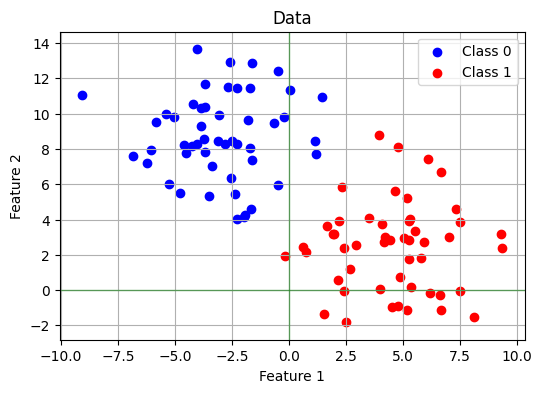

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(samples, labels):
  plt.figure(figsize=(6, 4))
  class0 = samples[labels == 0]
  class1 = samples[labels == 1]
  plt.scatter(class0[:, 0], class0[:, 1], c='blue', label='Class 0')
  plt.scatter(class1[:, 0], class1[:, 1], c='red', label='Class 1')
  plt.title('Data')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()
  plt.grid(True)
  plt.xlim(np.min(samples[:,0])-1, np.max(samples[:,0])+1)
  plt.ylim(min(-1, np.min(samples[:,1])-1), np.max(samples[:,1])+1)
  plt.axhline(y=0, color='green', linewidth=1, alpha=0.5)
  plt.axvline(x=0, color='green', linewidth=1, alpha=0.5)

  plt.show()

visualize_data(samples, labels)

### Model
If we look at the visualization above, it's very easy to draw a line that separates the samples of the two classes from each other. This is what we mean by "linearly separable".

While not a great model, we can use a parametric line equation to create a binary linear classifier:

$y = mx + b$

The parameters of the model are `m`, the line's slope, and `b`, the bias.

To make predictions using this model, we take a sample and plug in its `x` coordinate. The model then generates a `y` coordinate for us, based on the line slope and bias. If the sample's actual `y` coordinate is above the predicted `y` coordinate, then we assign the label `0` to the line, otherwise `0`. The line is called a **decision boundary**, as we use it to decide which class a sample belongs to.

This model has some (severe) deficiencies, which we'll explore later. For now, let us put the above model architecture into a simple function to predict the label of a sample given the model's parameters `m` and `b`.

In [ ]:
def predict(m, b, sample):
  x, y = sample
  line_y = m * x + b
  return 0 if y > line_y else 1

We can then use the `ipywidgets` package to create an interactive visualization to explore such a model's parameters `m` and `b` and their effect on prediciting the label of one or more samples.

The visualization lets us manually set `m` and `b`, uses the `predict` function to generate labels for all our samples, and then visualizes the result, including the line modelled by the parameters.

In [ ]:
import ipywidgets as widgets

def visualize_model(m, b, samples, labels):
  m_slider = widgets.FloatSlider(description='m (slope)', min = -4, max=4)
  m_slider.value = m
  b_slider = widgets.FloatSlider(description='b (bias)', min=0, max=10)
  b_slider.value = b

  def plot_model_and_data(m, b):
    plt.figure(figsize=(6, 4))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.xlim(np.min(samples[:,0])-1, np.max(samples[:,0])+1)
    plt.ylim(min(-1, np.min(samples[:,1])-1), np.max(samples[:,1])+1)
    plt.axhline(y=0, color='green', linewidth=1, alpha=0.5)
    plt.axvline(x=0, color='green', linewidth=1, alpha=0.5)

    # Draw the model line
    x_values = np.array([np.min(samples[:,0])-1, np.max(samples[:,0])+1])
    y_values = m*x_values + b
    plt.plot(x_values, y_values, '-r', label=f'y = {m:.2f}x + {b:.2f}')

    # Predict labels for the samples based on the current model and
    predicted_labels = np.array([predict(m, b, sample) for sample in samples])

    # Draw the samples, colored by class
    class0 = samples[predicted_labels == 0]
    class1 = samples[predicted_labels == 1]
    plt.scatter(class0[:, 0], class0[:, 1], c='blue', label='Class 0')
    plt.scatter(class1[:, 0], class1[:, 1], c='red', label='Class 1')

    plt.legend(loc='best')
    plt.show()

  out = widgets.interactive_output(plot_model_and_data, {'m': m_slider, 'b': b_slider})
  return widgets.VBox([m_slider, b_slider, out])

visualize_model(0, 0, samples, labels)

We can manually play with the slope and bias slider, until we find values for our model parameters `m` and `b` that we think produce a line that separates the samples of the 2 classes well, just based on visual inspection.

But that's not very precise, nor efficient, nor will we be able to do it for more complex or higher dimensional datasets.

Instead, we need an objective measure that tells us how well the model can separate the samples of the two classes via its decision boundary. That is what we use **loss functions** for.

The most naive loss function in this case would be to count the number of samples the current model predicts the labels for correctly, divided by the total number of samples. This is the accuracy metric mentioned in the evaluation section above.

In [ ]:
def accuracy(predicted_labels, labels):
    correct_predictions = sum(p == l for p, l in zip(predicted_labels, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

To turn it into a loss function, that goes down as more samples are labeled correctly, we need to invert it, that is, subtract the accuracy from 1.

In [ ]:
def loss(predicted_labels, labels):
    return 1 - accuracy(predicted_labels, labels)

We can modify our visualization above, to also output the loss each time we change a parameter. This way, we are no longer as dependent on visually judging how well the current model works.

In [ ]:
def visualize_model(m, b, samples, labels):
  m_slider = widgets.FloatSlider(description='m (slope)', min = -4, max=4)
  m_slider.value = m
  b_slider = widgets.FloatSlider(description='b (bias)', min=0, max=10)
  b_slider.value = b
  loss_label = widgets.Label(value='Loss: ')
  def plot_model_and_data(m, b):
    plt.figure(figsize=(6, 4))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.xlim(np.min(samples[:,0])-1, np.max(samples[:,0])+1)
    plt.ylim(min(-1, np.min(samples[:,1])-1), np.max(samples[:,1])+1)
    plt.axhline(y=0, color='green', linewidth=1, alpha=0.5)
    plt.axvline(x=0, color='green', linewidth=1, alpha=0.5)

    # Draw the model line
    x_values = np.array([np.min(samples[:,0])-1, np.max(samples[:,0])+1])
    y_values = m*x_values + b
    plt.plot(x_values, y_values, '-r', label=f'y = {m:.2f}x + {b:.2f}')

    # Predict labels for the samples based on the current model and
    predicted_labels = np.array([predict(m, b, sample) for sample in samples])
    loss_label.value = f"Loss: {loss(predicted_labels, labels): .3f}"

    # Draw the samples, colored by class
    class0 = samples[predicted_labels == 0]
    class1 = samples[predicted_labels == 1]
    plt.scatter(class0[:, 0], class0[:, 1], c='blue', label='Class 0')
    plt.scatter(class1[:, 0], class1[:, 1], c='red', label='Class 1')

    plt.legend(loc='best')
    plt.show()

  out = widgets.interactive_output(plot_model_and_data, {'m': m_slider, 'b': b_slider})
  return widgets.VBox([m_slider, b_slider, loss_label, out])

visualize_model(0, 0, samples, labels)

We can now adjust the slides until the loss becomes (close to) 0, and manually optimize the model parameters.

We can also write some naive model training code to do this work for us.

### Training
Our training algorithm will simulate us randomly adjusting the sliders, thus modifying `m` and `b`, for a couple of iterations. Of course, we won't have the machine interact with a UI.

The training algorithm works like this:
* **Input**:
  * The initial `m` and `b`, we can set them to 0, or initialize them randomly
  * The training `samples` and their `labels`
  * The `loss_function`to calculate how well the current model parameters work
  * The number of `epochs`, which is the number of times we adjust the parameters, and evaluate them on the full training set
  * The `learning_rate`, which defines how much we want to adjust the parametess in each epoch
* For `epochs` iterations
  1. Predict labels for all training samples using these modified model parameters
  2. Calculate the loss and store it
  2. If the loss is smaller than the previous best loss, record the current model parameters and loss as the best parameters and loss
  3. **"Optimize"** the best model parameters `m` and `b` so far, by adding a random number between `0-1`, scaled by the `learning_rate`
* **Output**: the best model parameters and loss, along with the history of losses

In [ ]:
import random

def train(m, b, samples, labels, loss_function, epochs, learning_rate):
  min_loss = float('inf')
  best_m, best_b = m, b
  losses = []

  for _ in range(epochs):
    # Predict labels with new parameters
    predicted_labels = [predict(m, b, sample) for sample in samples]

    # Calculate loss and record it
    current_loss = loss_function(predicted_labels, labels)
    losses.append(current_loss)

    # Update best parameters if loss improved
    if current_loss < min_loss:
      min_loss = current_loss
      best_m, best_b = m, b

    # Randomly adjust m and b
    m_adjust = random.random() * learning_rate
    b_adjust = random.random() * learning_rate

    m = m + m_adjust
    b = b + b_adjust

  return best_m, best_b, min_loss, losses

We can now train a model based on our data. As is common practice, we split the data into 80% for training (training set), and 20% for evaluation (test set). This is also referred to a **train/test split** of the data.



In [ ]:
from sklearn.model_selection import train_test_split
training_samples, test_samples, training_labels, test_labels = train_test_split(samples, labels, test_size=0.2, random_state=7)

Now let us train our model, giving it 200 epochs to find good model parameters. The inital `m` and `b`are set to zero. They could also be randomly initialized. The learning rate is set to 1, which means the parameters will be updated by a value between 0 and 1 for each epoch.

In [ ]:
m, b, best_loss, losses = train(0, 0, training_samples, training_labels, loss, 100, 1)
visualize_model(m, b, training_samples, training_labels)

We can also visualize the loss during training

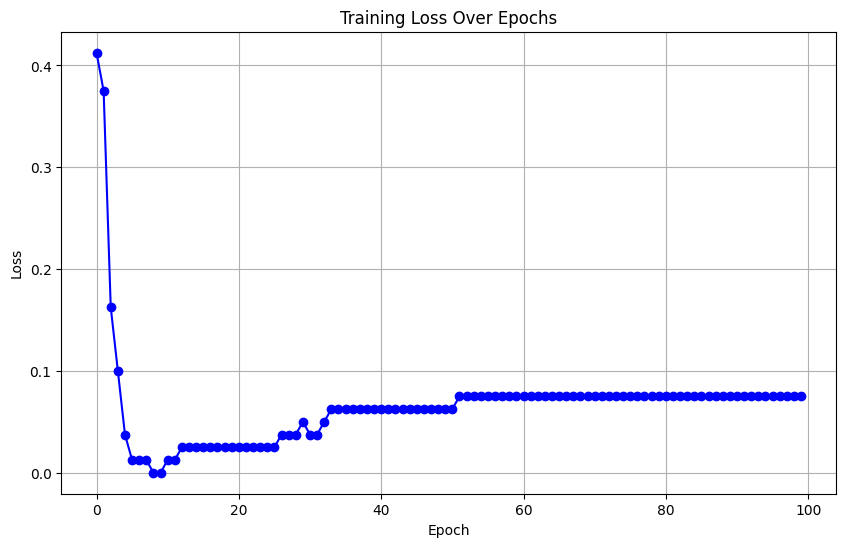

In [ ]:
def visualize_loss(losses):
  plt.figure(figsize=(10, 6))
  plt.plot(losses, marker='o', linestyle='-', color='blue')
  plt.title('Training Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.show()

visualize_loss(losses)

The best loss was found after only 8 epochs. The model parameters for that epoch were choosen to be the final model parameters, as subsequent epochs yielded worse loss.


### Evaluation
How does the trained model fare previously unseen data, such as the data in the test set? We can calculate the accuracy of the model for the test set:

In [ ]:
accuracy([predict(m, b, sample) for sample in test_samples], test_labels)

1.0

A value of `1` means that the model was able to assign a correct label to each sample in the test set. We can also visualize this.



In [ ]:
visualize_model(m, b, test_samples, test_labels)

Based on this evaluation, it appears that the model generalizes well.

However, as stated earlier, this model has severe deficiencies. Let us analyze them.

To begin with, let us swap the labels for each sample. That is, `0` becomes `1` and `1` becomes `0`.

In [ ]:
swapped_labels = np.array([1 if label == 0 else 0 for label in labels])

The samples stayed the same, only the labels changed, indicated by the swapped colors of the samples in this plot:

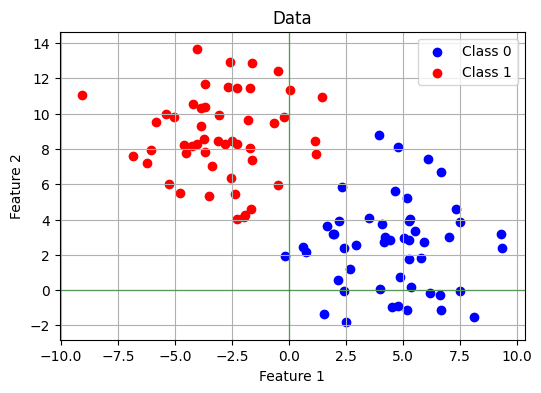

In [ ]:
visualize_data(samples, swapped_labels)

We can train a new model on this dataset. We'd expect it to arrive at the same or a similar set of model parameters.

In [ ]:
m, b, best_loss, losses = train(0, 0, samples, swapped_labels, loss, 100, 1)
visualize_model(m, b, training_samples, training_labels)

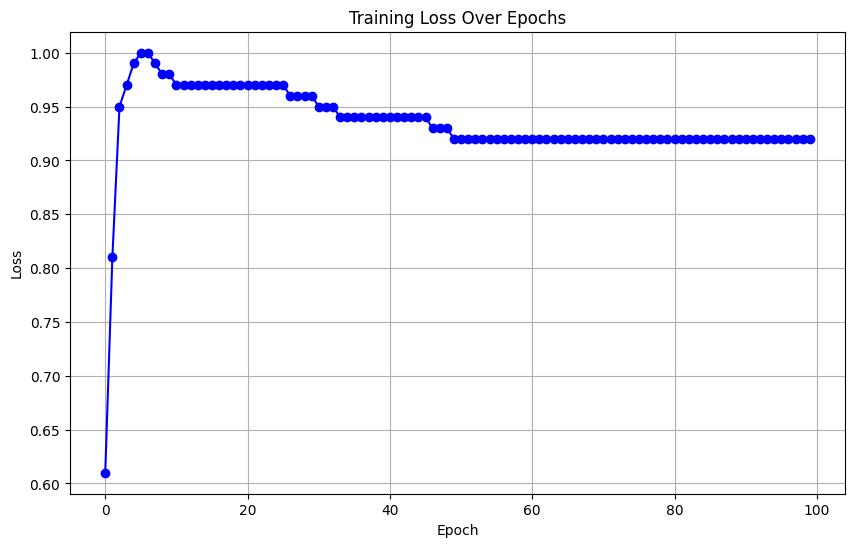

In [ ]:
visualize_loss(losses)

However, it clearly fails to do so. In fact, the training loss increases.

The problem lies with our simplicist `predict` function. It will always assign class `0` to points above the decision boundary, and class `1` to points below the boundary.

However, in the training dataset, the classes are swapped, and the samples of class `1` are always above the decision boundary. The model will thus always assign the wrong label to those samples, and is unable to make any meaningful progress.

This model this has **inherent limitations**: it can only be used for:
1. Data that can be classified into one of two classes
2. Data that is two dimensional
3. Data, where the samples with label `0` are assumed to be above the model's decision boundary, and samples with label `1` are assumed to be below the decision boundary.

While these limitations are extreme, similar limitations may crop up in real-world applications when using much more complex models. However, as in the case above, these limitations might not be apparent during development, as the training and test set might not allow us to identify such issues.

## A binary linear neural network classifier
Let's create a better, more realistic classifier. All the same principles will apply.

As a model, we will use a [fully connected linear feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network), with 2 input neurons (one for each input feature) and 2 output neurons (one for each class). We will train the model using a stochastic gradient descent optimizer with [cross-entropy loss function](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1). We do not care about the mathematical intricacies here. Instead we want to focus on the general "workflow" of training and evaluating a supervised machine learning model.

> **Note:** In practical applications, we may often also not care much for the internals of a model and simply treat it as a parameterized black box that takes some input and generates some output. We also need to understand the limitations of a model to successfully apply it to a task. This too does not necessarily require us to understand the internals of the model either. All that said, a deeper understanding of iternal mechanics is always beneficial.

We will be using [PyTorch](https://pytorch.org/), a machine learning framework, to train and evalute the model. We will reuse the training set and test set data we generated above for comparison.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

### Data

As a first step, we need to convert our sample and label data to [PyTorch tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html). These are optimized data structures to store vectors (lists of numbers), matrices (two dimensional arrays of number), or more generally tensors. They also allow us to push the data to GPUs or TPUs for faster processing.





In [ ]:
training_samples_torch = torch.tensor(training_samples, dtype=torch.float)
training_labels_torch = torch.tensor(training_labels, dtype=torch.long)
test_samples_torch = torch.tensor(test_samples, dtype=torch.float)

Next, we create [PyTorch data sets](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Data sets wrap our samples and labels and make them easier to handle.

In [ ]:
training_set_torch = TensorDataset(training_samples_torch, training_labels_torch)

### Model

Next, we define our linear feedfoward neural network using Torch's [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class. The first parameter specifies the number of input features. The second parameter defines the number of classes.

In [ ]:
nn_model = nn.Linear(2, 2)
nn_model

Linear(in_features=2, out_features=2, bias=True)

We also need a function to make predictions for a new sample. The function `predict_nn` takes a model and one or more samples, where each sample is a tensor with the same number of features that the model was configured with.

It then uses the model to make a prediction. The prediction isn't the class to be assigned to the sample directly, but a list of probabilities, one for each class. We return the class with the highest probability.

> **Note:** passing only a simple sample to the model for prediction is not very efficient, especially if we perform inference on a GPU or TPU. The function thus expects an array of sample tensors, and returns an array of labels

In [ ]:
def predict_nn(model, samples):
    with torch.no_grad():  # Disable gradient computation for inference
        logits = model(samples)
        _, predictions = torch.max(logits, dim=1)
    return predictions

### Training
For training, we use Torch's [stochastic gradient descent optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), which will adjust the models parameters during training based on the gradients generated by an instance of Torch's [Cross-Entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) class. To iterate over the training set, we'll use Torch's [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class. It cuts up the training data into batches of a specific size, which we then present to the model for prediction. This batching mechanism is needed by many models, be it because the full training set does not fit into working memory, because the model can only deal with a maximum number of samples at a time, or because the model will generalize better when optimized per batch, instead of the full training set.

The training loop conceptually works very similar to our naive training procedure above:

* For each epoch, we iterate through the training set one batch at a time (`batch_size=10`).
  * For each batch we:
    1. Reset the gradients in the optimizer
    2. Get a prediction for each training sample in the batch
    3. Calculate the loss by comparing the predicted labels with the expected labels
    4. Perform back propagation to calculate new gradients
    5. Use the gradients to update the parameters of the neural network via the optimizer

We also keep track of the average training loss for each epoch. Let's put all this into a new training function called `train_nn`:

In [ ]:
def train_nn(model, training_set, epochs, learning_rate=0.01):
  optimizer = SGD(model.parameters(), lr=learning_rate)
  loss_function = nn.CrossEntropyLoss()
  training_loader = DataLoader(training_set, batch_size=10, shuffle=True)
  losses = []

  for epoch in range(epochs):
    total_loss = 0.0

    for samples, labels in training_loader:
      optimizer.zero_grad()
      outputs = model(samples)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    average_loss = total_loss / len(training_loader)
    losses.append(average_loss)

  return losses

Let's train the model:

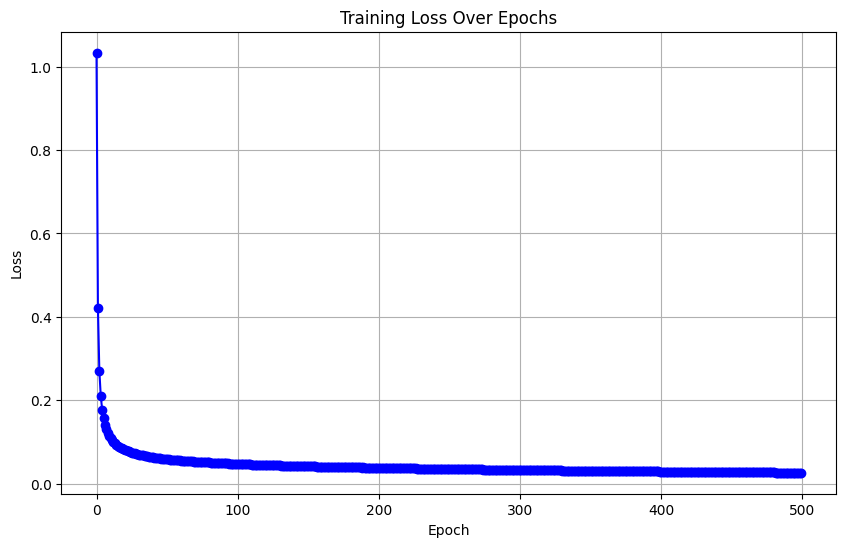

In [ ]:
losses = train_nn(nn_model, training_set_torch, 500, 0.01)
visualize_loss(losses)

The model converged more or less quickly at around epoch 50. Subsequent improvements were not big in terms of training loss. As such, we could have stopped training earlier.

We can also calculate the accuracy of the model on the training set.

In [ ]:
nn_model.eval()
with torch.no_grad():
    predicted_labels = predict_nn(nn_model, training_samples_torch)
    print(f"Accuracy: {accuracy(predicted_labels, training_labels)}")

Accuracy: 0.987500011920929


The model could not achieve 100% accuracy on the training set, despite it being easily linearly separable. Let's investigate.

### Evaluation
We can now evaluate how the model behaves on unseen data and whether it generalizes.

To do so, we switch the model to evaluation mode and disable the calculation of gradients, which are only necessary for training. This makes computation more efficient and reduces memory usage.

We then predict the label of each test sample and calculate the accuracy accordingly.

We can also calculate the model's accuracy on the training set:

In [ ]:
nn_model.eval()
with torch.no_grad():
    predicted_labels = predict_nn(nn_model, test_samples_torch)
    print(f"Accuracy: {accuracy(predicted_labels, test_labels)}")

Accuracy: 1.0


As before, we can also visualize the labels the model assigned to the test data graphically. We can also visualize the models decision boundary by generating a grid of points, predicting labels for them, and using a contour plot to color the background of the visualization.

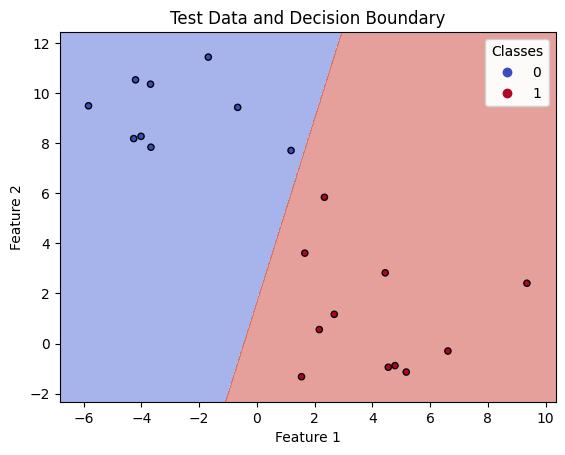

In [ ]:
def visualize_model_nn(model, test_samples, test_labels):
    # Create a mesh to plot the decision boundaries
    x_min, x_max = test_samples[:, 0].min() - 1, test_samples[:, 0].max() + 1
    y_min, y_max = test_samples[:, 1].min() - 1, test_samples[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on the mesh grid
    mesh_samples = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    mesh_predictions = predict_nn(model, mesh_samples).reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, mesh_predictions, alpha=0.5, cmap='coolwarm')

    # Scatter plot the test data
    scatter = plt.scatter(test_samples[:, 0], test_samples[:, 1], c=test_labels, cmap='coolwarm', edgecolor='k', s=20)
    plt.title('Test Data and Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend)
    plt.show()
visualize_model_nn(nn_model, test_samples, test_labels)

We can now also visualize the models output for the training set a little better, and see, that it was unable to classify one sample from class `1` correctly.

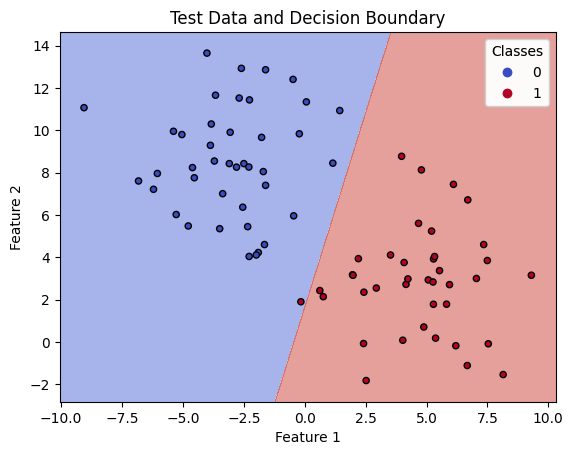

In [ ]:
visualize_model_nn(nn_model, training_samples, training_labels)

Ideally, the decision boundary would be located such that the samples of each class are as far away from it as possible. This would yield better generalization, and also fix the one misclassified sample of class `1` in the training set.

We can try to more complex neural network model.

## A (not so) deep neural network classifier
Creating a more complex neural network is very simple with Torch. Let's create a neural network architecture that has:

1. A linear layer with 2 inputs and 64 outputs
2. Another linear layer with 64 inputs and 64 outputs
3. A final layer with 64 inputs and 2 outputs

The first layer's input size is equal to the number of features of our samples. The last layer's output size is equal to the number of classes. The additional hidden layer gives the model more "degrees of freedom" when it learns how the data is shaped.

We also need to decide on an activation function, that is, a function that is used to calculate a value based on the weighted inputs to a neuron. A common choice is the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function.

Here's how we can define and instantiate this model:

In [ ]:
class SimpleDeepNet(nn.Module):
  def __init__(self, input_size=2, hidden_size=64, output_size=2):
    super(SimpleDeepNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
    self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

  def forward(self, x):
    x = F.relu(self.fc1(x))  # Activation function for hidden layer
    x = self.fc2(x)  # No activation here if using CrossEntropyLoss
    return x

deepish_nn_model = SimpleDeepNet(2, 64, 2)

Next we can train the model as before.

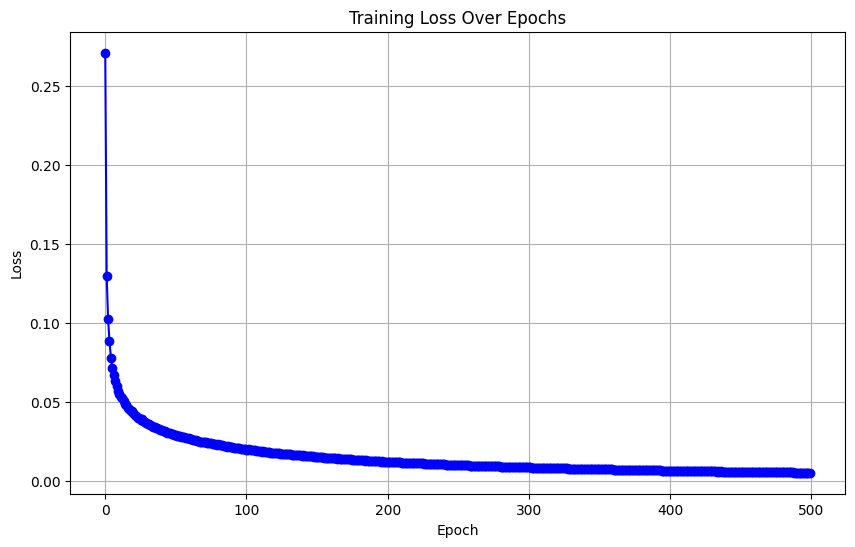

In [ ]:
losses = train_nn(deepish_nn_model, training_set_torch, 500, 0.01)
visualize_loss(losses)

What is the model's accuracy on the training set?

In [ ]:
deepish_nn_model.eval()
with torch.no_grad():
    predicted_labels = predict_nn(deepish_nn_model, training_samples_torch)
    print(f"Accuracy: {accuracy(predicted_labels, training_labels)}")

Accuracy: 1.0


Looks like it got it perfectly. Let's see how it does on previously unseen samples from the test set.

In [ ]:
with torch.no_grad():
    predicted_labels = predict_nn(deepish_nn_model, test_samples_torch)
    print(f"Accuracy: {accuracy(predicted_labels, test_labels)}")

Accuracy: 1.0


And finally, let's have a look at the decision boundary it learned.

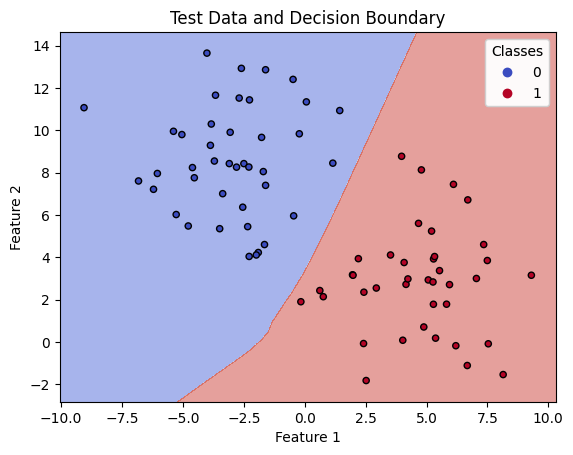

In [ ]:
visualize_model_nn(deepish_nn_model, training_samples, training_labels)

As we can see, the decision boundary is no longer just a straight line. Due to the model's hidden layer, it is able to learn non-linear decision boundaries, thereby better modelling the training data, and hopefully, the true data distribution.

Also note, how we could re-use all our previous code for training, evaluation, and visualization. Modern machine learning is quite modular, and many concepts and mechanisms like loss function, optimizer, or evaluation metrics transfer nicely between machine learning models.

It also enables us to combine multiple models to form a single model, to build even more powerful machine learning applications.